# 프로젝트 설명

해당 프로젝트는 train 데이터 50% 훈련+sparse_categorical_crossentropy 손실함수 + 이미지 크기 512 버전입니다. 즉 v2 코드에서 훈련 데이터만 50%로 줄인 것과 같습니다.

다만 결과를 분석하기 편하게 과대과소적합인지 판단하는 그래프를 작성했습니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 훈련 데이터 파일 압축풀기 (자신의 경로에 맞게 세팅 필요!)

In [ ]:
!tar -xvf '/content/drive/MyDrive/Colab_Notebooks/xBD/train_images_labels_targets.tar' -C '/content/'

In [ ]:
!ls train
# socal-fire_00001357_post_disaster_target.png
# socal-fire_00001357_pre_disaster_target.png

images	labels	targets


# 단일 사진 클래스 개수 확인

In [ ]:
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

# 파일 경로(사진경로)
label_image_path = '/content/train/targets/guatemala-volcano_00000000_pre_disaster_target.png'

# 이미지 로드
label_image = Image.open(label_image_path)

# 이미지를 numpy 배열로 변환
label_image_array = np.array(label_image)

# 레이블 이미지의 고유값과 분포 시각화
unique, counts = np.unique(label_image_array, return_counts=True)

# 고유값 분포를 프린트
print("Unique pixel values in label image:", unique)
print("Counts for each value:", counts)


Unique pixel values in label image: [0 1]
Counts for each value: [1032725   15851]


In [ ]:
input_dir = 'train/images'
target_dir = 'train/targets'
img_size = (512, 512)
num_classes = 2
batch_size = 1

input_img_paths = sorted([ os.path.join(input_dir, fname)
                           for fname in os.listdir(input_dir)
                           if fname.endswith('pre_disaster.png')])

target_img_paths = sorted([ os.path.join(target_dir, fname)
                           for fname in os.listdir(target_dir)
                           if fname.endswith('pre_disaster_target.png')])

print(input_img_paths[7])

print(target_img_paths[7])

train/images/guatemala-volcano_00000013_pre_disaster.png
train/targets/guatemala-volcano_00000013_pre_disaster_target.png


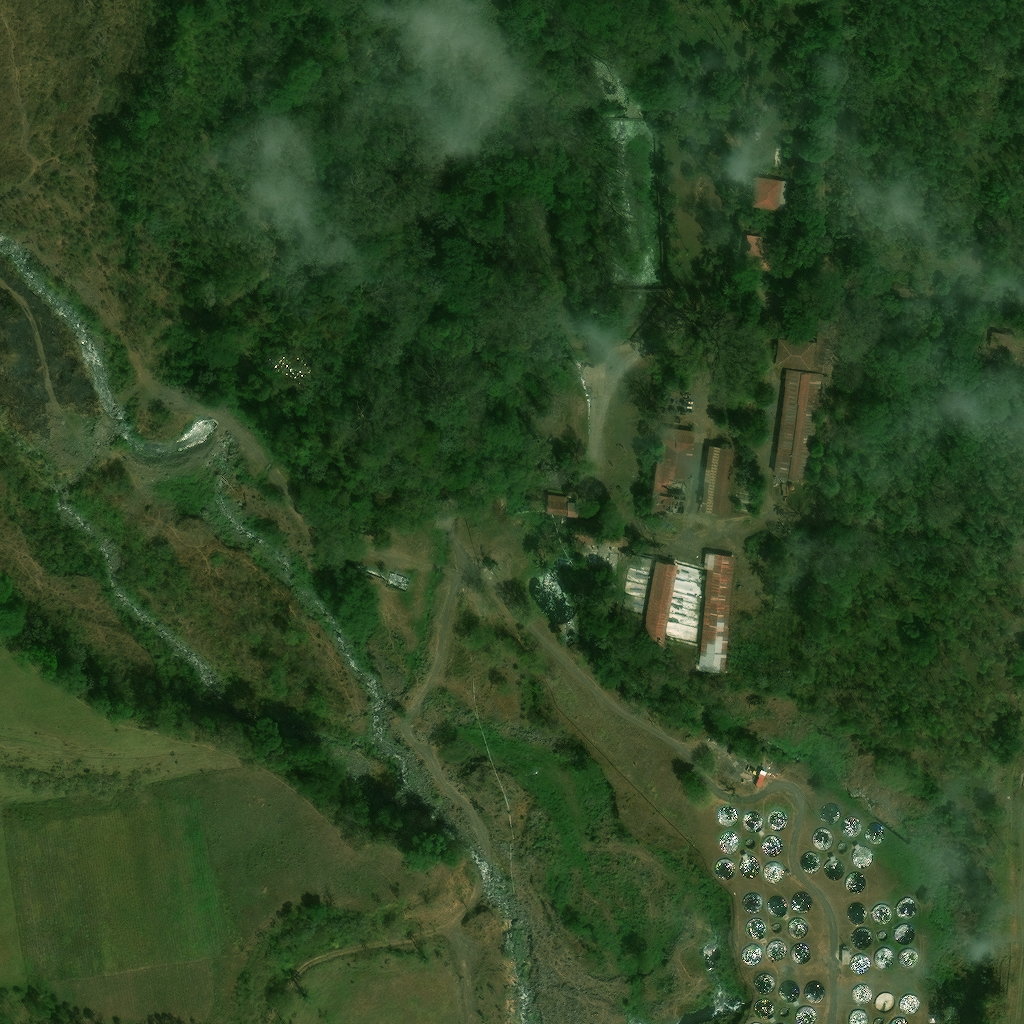

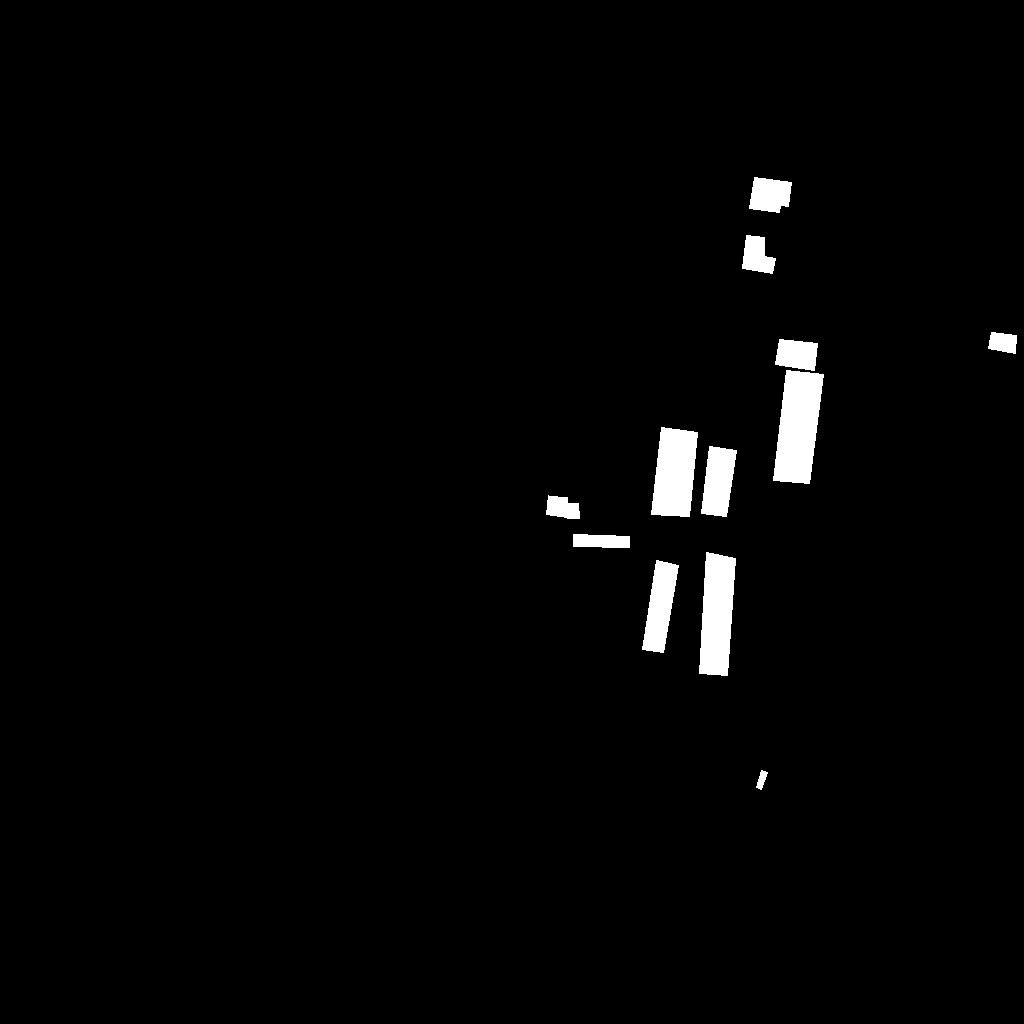

In [ ]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import PIL
from PIL import ImageOps

display(Image(filename=input_img_paths[7]))
img = ImageOps.autocontrast(load_img(target_img_paths[7]))
display(img)
# class0: black class1: white

## 데이터 전처리

In [ ]:
from tensorflow import keras

class xBD(keras.utils.Sequence):
  def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
    self.batch_size = batch_size
    self.img_size = img_size
    self.input_img_paths = input_img_paths
    self.target_img_paths = target_img_paths

  def __len__(self):
    return len(self.target_img_paths) // self.batch_size

  def __getitem__(self, idx):
    i = idx * self.batch_size
    batch_input_img_paths = self.input_img_paths[i:i+self.batch_size]
    batch_target_img_paths = self.target_img_paths[i:i+self.batch_size]
    x = np.zeros((self.batch_size, ) + self.img_size + (3, ), dtype='float32')
    for j, path in enumerate(batch_input_img_paths):
      img = load_img(path, target_size=self.img_size)
      x[j] = img
    y = np.zeros((self.batch_size, ) + self.img_size + (1, ), dtype='uint8')
    for j, path in enumerate(batch_target_img_paths):
      img = load_img(path, target_size=self.img_size, color_mode='grayscale')
      y[j] = np.expand_dims(img, 2)

    return x, y


In [ ]:
import random

val_samples = 500 # 검증용 데이터셋 500개
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

# input_img_paths랑 target_img_path 50%만 저장
input_img_paths = input_img_paths[:len(input_img_paths)//2]
target_img_paths = target_img_paths[:len(target_img_paths)//2]

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

train_gen = xBD(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = xBD(batch_size, img_size, val_input_img_paths, val_target_img_paths)

## 모델 구성

이진 분류 (sigmoid 사용):

출력 채널 수: 1 (하나의 확률 출력으로, 해당 클래스에 속할 확률을 나타냄)
활성화 함수: sigmoid (0과 1 사이의 값으로 출력을 제한, 이 값이 0.5 이상이면 하나의 클래스로, 그렇지 않으면 다른 클래스로 분류)
이진 분류 (softmax 사용):

출력 채널 수: 2 (두 개의 클래스 각각에 대한 확률을 출력)
활성화 함수: softmax (각 출력값을 확률로 변환하여 모든 클래스에 대한 확률의 합이 1이 되도록 함)
다중 클래스 분류 (softmax 사용):

출력 채널 수: 클래스 수에 해당하는 수
활성화 함수: softmax (위와 동일)

In [ ]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
  inputs = keras.Input(shape=img_size + (3,))

  x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  previous_block_activation = x

  for filters in [64, 128, 256]:
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    residual = layers.Conv2D(filters, 1, strides=2, padding='same')(previous_block_activation)
    x = layers.add([x, residual])
    previous_block_activation = x

  for filter in [256, 128, 64, 32]:
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D(2)(x)

    residual = layers.UpSampling2D(2)(previous_block_activation)
    residual = layers.Conv2D(filters, 1, padding='same')(residual)
    x = layers.add([x, residual])
    previous_block_activation = x

  outputs = layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)

  model = keras.Model(inputs, outputs)
  return model

model = get_model(img_size, num_classes)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 256, 256, 32)         896       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_15 (Ba  (None, 256, 256, 32)         128       ['conv2d_9[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 activation_15 (Activation)  (None, 256, 256, 32)         0         ['batch_normalization_15

## 모델 컴파일 및 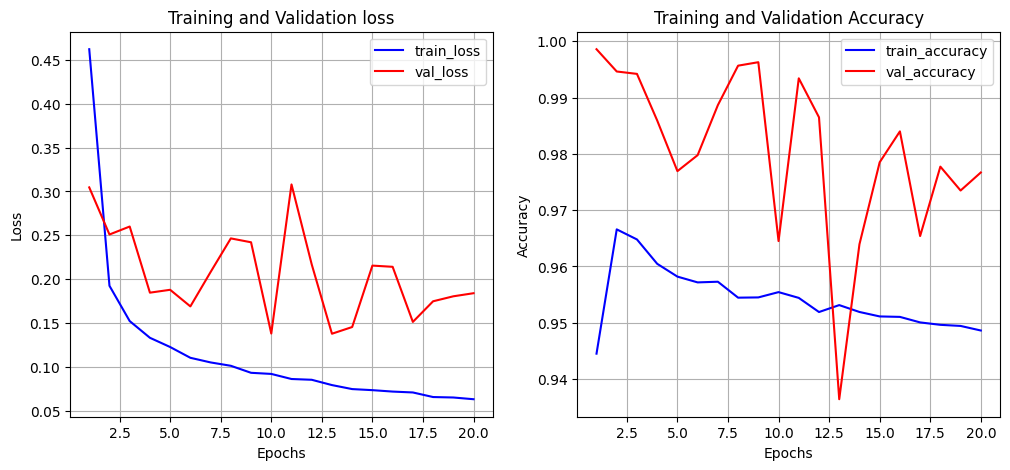학습

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint('xbd_segmentation_v8.h5', save_best_only=True)]

epochs = 20
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/20
899/899 [==============================] - ETA: 0s - loss: 0.4621 - accuracy: 0.9445

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


899/899 [==============================] - 88s 89ms/step - loss: 0.4621 - accuracy: 0.9445 - val_loss: 0.3047 - val_accuracy: 0.9986
Epoch 2/20
899/899 [==============================] - 80s 89ms/step - loss: 0.1925 - accuracy: 0.9666 - val_loss: 0.2510 - val_accuracy: 0.9946
Epoch 3/20
899/899 [==============================] - 79s 88ms/step - loss: 0.1523 - accuracy: 0.9648 - val_loss: 0.2601 - val_accuracy: 0.9942
Epoch 4/20
899/899 [==============================] - 80s 89ms/step - loss: 0.1333 - accuracy: 0.9605 - val_loss: 0.1847 - val_accuracy: 0.9859
Epoch 5/20
899/899 [==============================] - 81s 90ms/step - loss: 0.1227 - accuracy: 0.9582 - val_loss: 0.1880 - val_accuracy: 0.9769
Epoch 6/20
899/899 [==============================] - 80s 89ms/step - loss: 0.1105 - accuracy: 0.9572 - val_loss: 0.1690 - val_accuracy: 0.9798
Epoch 7/20
899/899 [==============================] - 80s 89ms/step - loss: 0.1052 - accuracy: 0.9573 - val_loss: 0.2082 - val_accuracy: 0.9887
Epo

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

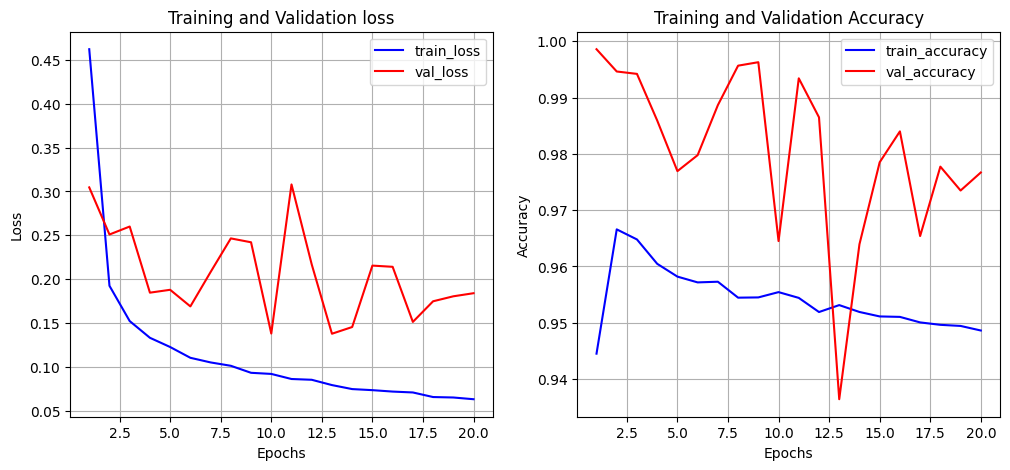

In [ ]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color='blue', label='train_loss')
ax1.plot(epochs, val_loss, color='red', label='val_loss')
ax1.set_title('Training and Validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']


ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, color='blue', label='train_accuracy')
ax2.plot(epochs, val_accuracy, color='red', label='val_accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

<ipython-input-33-7319c479d1d2>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


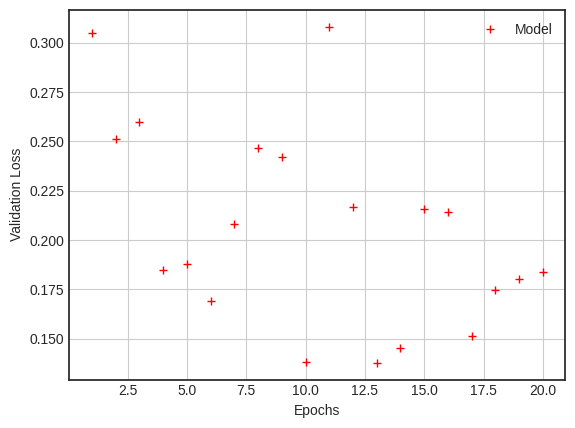

In [ ]:
plt.style.use('seaborn-white')

plt.plot(epochs, val_loss, 'r+', label='Model')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid()
plt.show()

## 과소적합(Underfitting) / 과대적합(Overfitting)

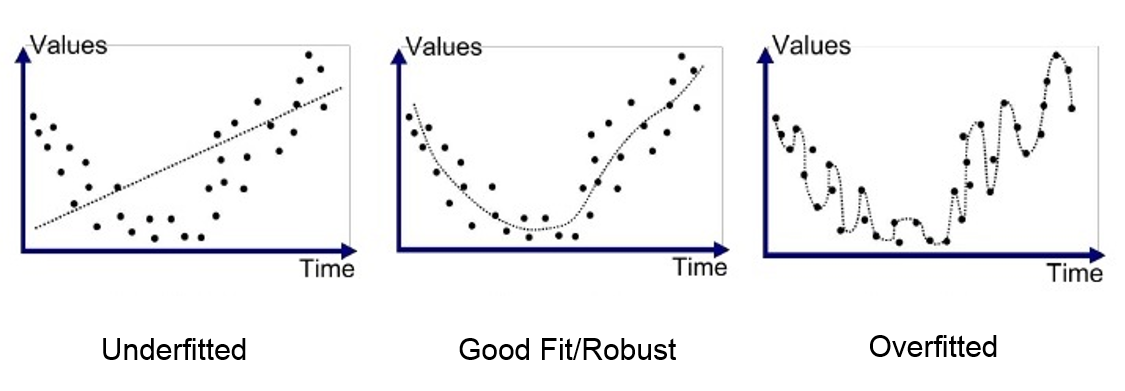

### 과소적합 (Underfitting)

- 학습 데이터를 충분히 학습하지 않아 성능이 매우 안 좋은 경우
- 모델이 지나치게 단순한 경우
- 해결 방안
  - 충분한 학습 데이터 수집
  - 보다 더 복잡한 모델 사용
  - 에폭수(epochs)를 늘려 충분히 학습

### 과대적합 (Overfitting)

- 모델이 학습 데이터에 지나치게 맞추어진 상태
- 새로운 데이터에서는 성능 저하
- 데이터에는 잡음이나 오류가 포함
- 학습 데이터가 매우 적을 경우
- 모델이 지나치게 복잡한 경우
- 학습 횟수가 매우 많을 경우
- 해결방안
  - 다양한 학습 데이터 수집 및 학습
  - 모델 단순화: 파라미터가 적은 모델을 선택하거나, 학습 데이터의 특성 수를 줄임
  - 정규화(Regularization)을 통한 규칙 단순화
  - 적정한 하이퍼 파라미터 찾기

### 과대적합(overfitting)과 과소적합(underfitting) 방지 방법

* 모델의 크기 축소
* 가중치 초기화(Weight Initializer)
* 옵티마이저(Optimizer)
* 배치 정규화(Batch Normalization)
* 규제화(Regularization)
* 드롭아웃(Dropout)

## 모델 평가 및 예측

In [ ]:
from tensorflow.keras.models import load_model

# .h5 파일로부터 모델 로드
model = load_model('/content/xbd_segmentation_v8.h5')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 256, 256, 32)         896       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_15 (Ba  (None, 256, 256, 32)         128       ['conv2d_9[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 activation_15 (Activation)  (None, 256, 256, 32)         0         ['batch_normalization_15

In [ ]:
!tar -xvf '/content/drive/MyDrive/Colab_Notebooks/xBD/test_images_labels_targets.tar' -C '/content/'

In [ ]:
input_dir = 'test/images'
target_dir = 'test/targets'
img_size = (512, 512)
batch_size = 1

input_img_paths = sorted([ os.path.join(input_dir, fname)
                           for fname in os.listdir(input_dir)
                           if fname.endswith('pre_disaster.png')])

target_img_paths = sorted([ os.path.join(target_dir, fname)
                           for fname in os.listdir(target_dir)
                           if fname.endswith('pre_disaster_target.png')])

test_input_img_paths = input_img_paths
test_target_img_paths = target_img_paths

test_gen = xBD(batch_size, img_size, test_input_img_paths, test_target_img_paths)

In [ ]:
model.evaluate(test_gen)

933/933 [==============================] - 41s 43ms/step - loss: 0.1327 - accuracy: 0.9444


[0.13268812000751495, 0.9444437026977539]

In [ ]:
import math

# 추론용 데이터 제너레이터 클래스 정의
class xBDInference(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths

    def __len__(self):
        return math.ceil(len(self.input_img_paths) / self.batch_size)

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i: i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype='float32')
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        return x


# 2. 테스트셋 이미지 모델 추론

In [ ]:
test_gen = xBDInference(batch_size, img_size, test_input_img_paths)

test_preds = model.predict(test_gen)

933/933 [==============================] - 37s 39ms/step


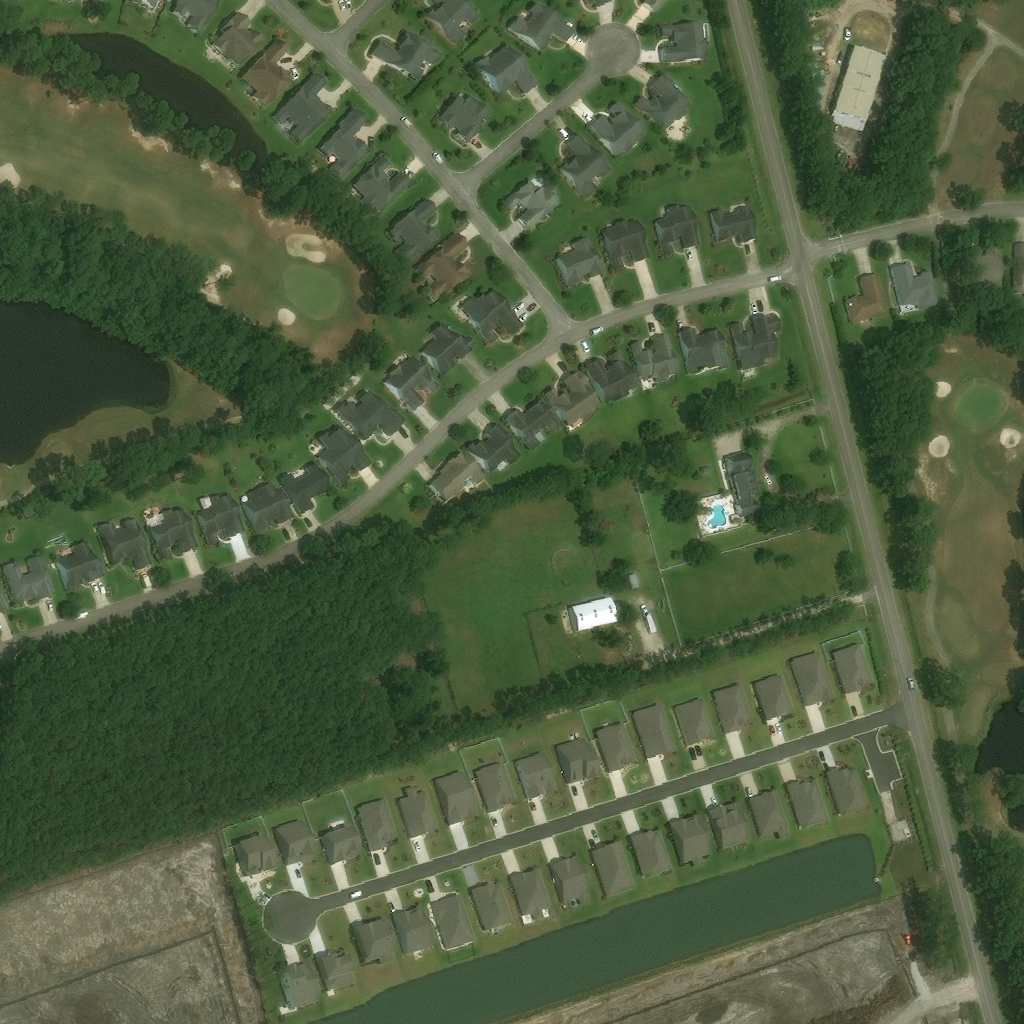

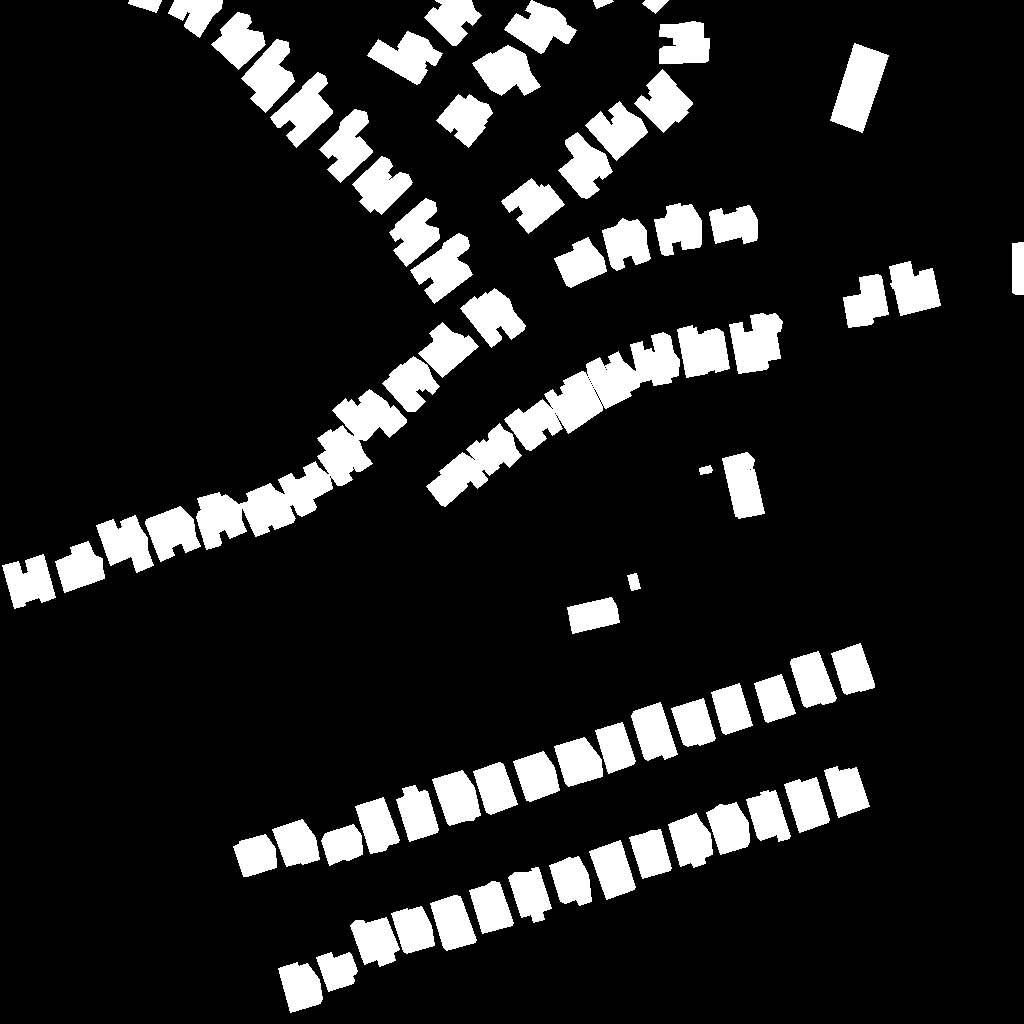

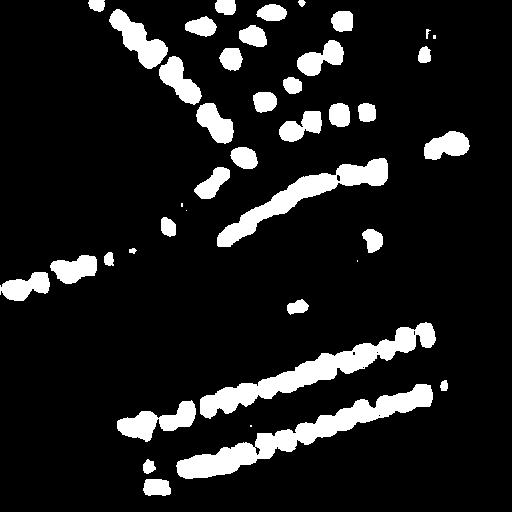

In [ ]:
from tensorflow.keras.preprocessing.image import array_to_img

def display_mask(i):
  mask = np.argmax(test_preds[i], axis=-1)
  mask = np.expand_dims(mask, axis=-1)
  img = PIL.ImageOps.autocontrast(array_to_img(mask))
  display(img)

# 예측 결과 출력
i = 5

display(Image(filename=test_input_img_paths[i]))
img = ImageOps.autocontrast(load_img(test_target_img_paths[i]))
display(img)
display_mask(i)

## xBD 테스트셋 데이터 추론 마스크 결과 사진 저장

In [ ]:
# 저장할 폴더 경로
save_dir = "/content/drive/MyDrive/Colab_Notebooks/xBD/test_predicts_v8"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)


In [ ]:
def save_mask(i, input_img_paths, save_dir):
    # 입력 이미지 경로에서 파일 이름 추출
    original_filename = os.path.basename(input_img_paths[i])
    # 파일 확장자 제거
    filename_without_extension = os.path.splitext(original_filename)[0]

    # 추론한 마스크 생성
    mask = np.argmax(test_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(array_to_img(mask))

    # 마스크를 저장할 파일 이름 설정 (원본 파일 이름에 '_mask' 추가)
    save_path = os.path.join(save_dir, f"{filename_without_extension}_mask.png")

    # 생성된 마스크를 지정된 폴더에 저장
    img.save(save_path)

    print(f"Mask saved at: {save_path}")

In [ ]:
# test_preds에 저장된 모든 마스크에 대해 save_mask 함수를 호출하여 저장
for i in range(len(test_preds)):
    save_mask(i, test_input_img_paths, save_dir)

# MIOU 평가 (xBD test Data)



In [ ]:
y_true_arrays = [load_img(path, target_size=img_size, color_mode='grayscale') for path in test_target_img_paths]
y_true = np.array([np.expand_dims(np.array(img), axis=-1) for img in y_true_arrays])
y_true = y_true.squeeze() # 필요시 차원 축소
# 예측 레이블 준비

y_pred = np.argmax(test_preds, axis=-1)

# mIoU 계산
def mean_iou(y_true, y_pred, num_classes):
  intersection = np.zeros(num_classes)
  union = np.zeros(num_classes)
  for i in range(num_classes):
    intersection[i] = np.logical_and(y_true == i, y_pred == i).sum()
    union[i] = np.logical_or(y_true == i, y_pred == i).sum()
  iou = intersection / np.maximum(union, 1)
  mIoU = np.mean(iou)
  return mIoU

miou_score = mean_iou(y_true, y_pred, num_classes)
print("Mean IoU for the test set is:", miou_score)

Mean IoU for the test set is: 0.6931466865806055


# 결과

### accuracy: 0.9444
### MIOU: 0.6931466865806055

# 모델 성능 평가 보고서

## 1. 서론
본 보고서는 주어진 딥러닝 모델의 트레이닝, 검증, 그리고 테스트 데이터셋에 대한 성능 평가를 목적으로 합니다. 모델은 이미지 분류 및 분할 작업에 사용되었으며, 여기서는 모델의 학습 경향과 일반화 능력을 중점적으로 분석합니다.

## 2. 데이터 및 방법
모델의 성능을 평가하기 위해 에포크당 트레이닝 및 검증 손실과 정확도 데이터를 사용하였습니다. 테스트 데이터셋에서는 정확도와 평균 교차 IoU(MIOU)를 통해 모델의 일반화 능력을 평가했습니다.

### 2.1 그래프 분석
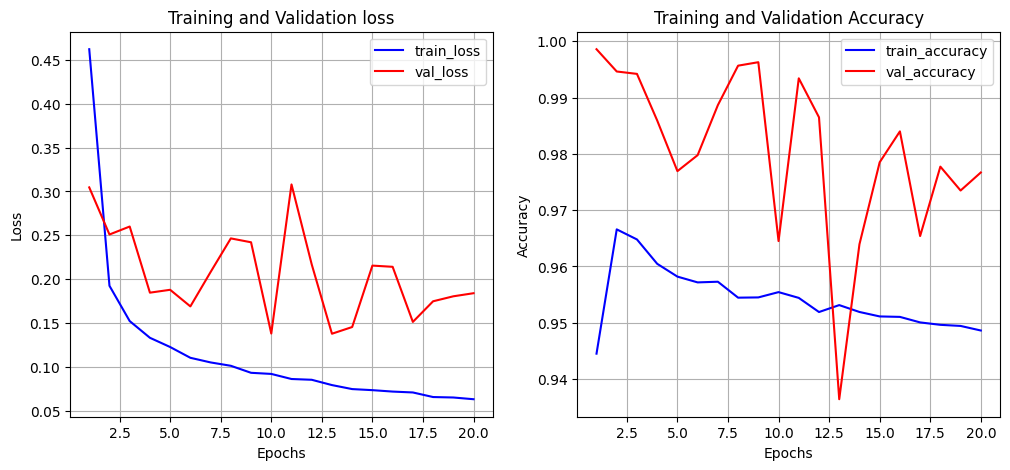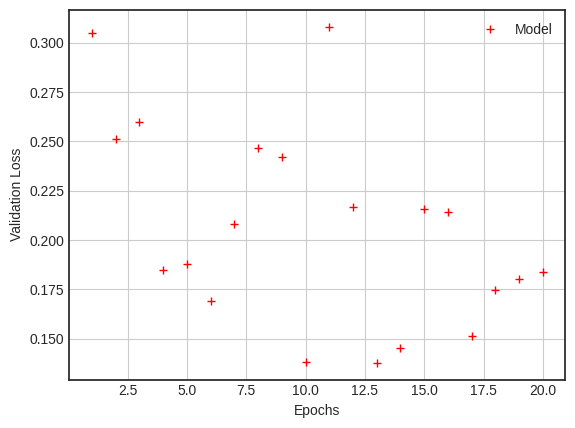
첫 번째 그래프는 검증 손실이 시간에 따라 점진적으로 감소하는 경향을 보여 주며, 이는 모델이 적절히 학습되고 있음을 시사합니다.
두 번째 그래프에서는 트레이닝 손실이 지속적으로 감소하는 반면, 검증 손실과 검증 정확도에서 불규칙한 변동이 관찰됩니다. 이는 모델이 트레이닝 데이터에 과적합되는 경향을 나타냅니다.

###2.2 테스트 데이터셋 결과
정확도: 94.44%
평균 교차 IoU: 69.31%

## 3. 결과 해석
분석 결과, 모델은 트레이닝 데이터에 대해서는 높은 정확도를 보이나, 검증 및 테스트 데이터셋에서는 일부 변동성과 과적합의 징후를 보입니다. 특히, MIOU가 상대적으로 낮게 나타남으로써 모델의 분할 능력에 개선이 필요함을 나타냅니다.

## 4. 토론 및 개선 제안
모델의 과적합 문제를 해결하기 위해 다음과 같은 전략을 제안합니다:

데이터 증강: 더 많은 데이터를 활용하거나 데이터 증강 기법을 도입하여 데이터의 다양성을 높여 일반화 능력을 향상시킬 수 있습니다.
정규화 기법 적용: 드롭아웃, 가중치 감쇠 등을 추가하여 모델의 복잡성을 조절합니다.
조기 종료: 검증 손실이 개선되지 않을 때 학습을 조기에 종료하여 과적합을 방지할 수 있습니다.

## 5. 결론
본 모델은 이미지 분류 작업에서 높은 정확도를 보이나, 이미지 분할 작업에 있어서는 아직 개선의 여지가 있는 것으로 나타났습니다. 제안된 개선 방향을 통해 모델의 성능을 더욱 향상시킬 수 있을 것으로 기대됩니다.